# **Classical-ML-Classifiers-Analysis**


# 1. Library Imports & Environment Setup
Importing necessary libraries for data manipulation, plotting, and machine learning models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Dataset Loaders
from sklearn.datasets import load_digits, load_breast_cancer, make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Settings
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading & Synthetic Generation
Loading three distinct datasets to test model performance under different conditions:
1.  **High-Dimensional:** Digits (64 features).
2.  **Noisy Data:** Breast Cancer dataset with added Gaussian noise.
3.  **Non-Linear:** Make Moons (Synthetic).


In [2]:
print("Loading datasets...")

# --- DATASET 1: High-Dimensional (Digits) ---
digits = load_digits()
X_high = digits.data
y_high = digits.target

# --- DATASET 2: Low-Feature & Noisy (Breast Cancer + Noise) ---
data_low = load_breast_cancer()
X_low_clean = data_low.data
y_low = data_low.target
# Adding Noise
noise = np.random.normal(0, 1, X_low_clean.shape)
X_low = X_low_clean + noise

# --- DATASET 3: Non-Linear (Moons) ---
X_nl, y_nl = make_moons(n_samples=1000, noise=0.2, random_state=42)

print(f"Datasets Loaded:")
print(f"  - High-Dim Shape: {X_high.shape}")
print(f"  - Noisy Shape:    {X_low.shape}")
print(f"  - Non-Linear Shape: {X_nl.shape}")

Loading datasets...
Datasets Loaded:
  - High-Dim Shape: (1797, 64)
  - Noisy Shape:    (569, 30)
  - Non-Linear Shape: (1000, 2)


# **Visualization of Datasets (New)**

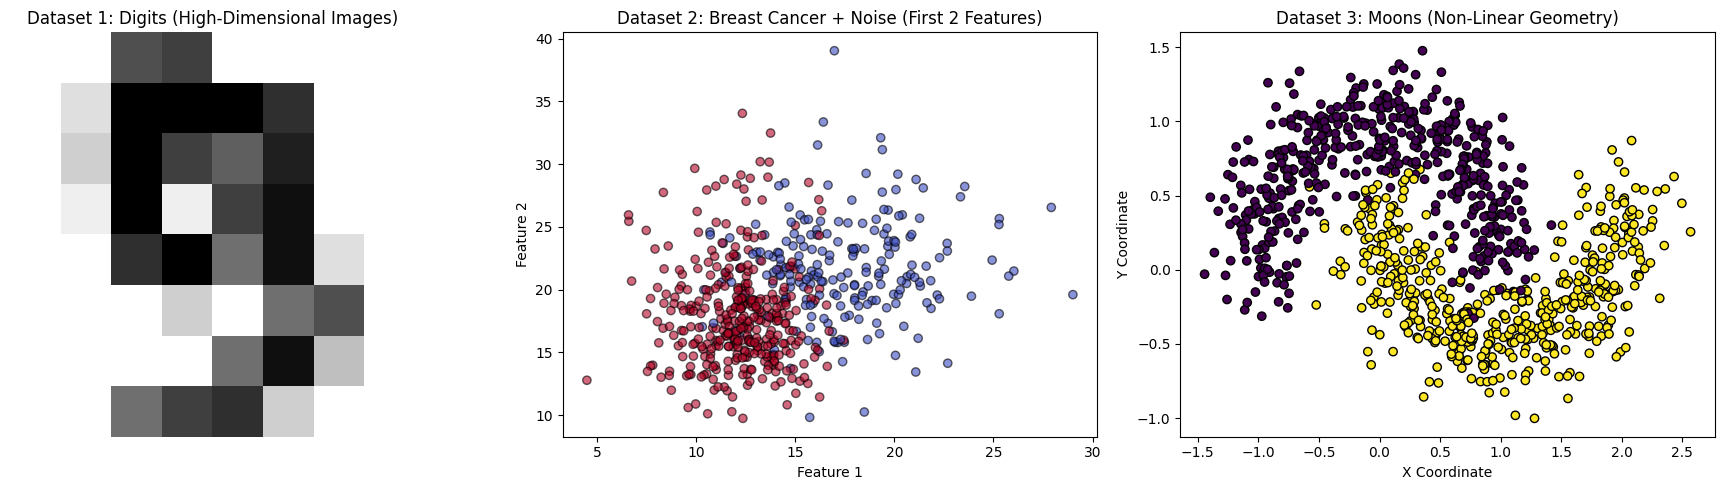

In [3]:
# 2.5. Visualize the Raw Datasets
# We create a figure to show what our data looks like before training.

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: High-Dimensional (Show first 10 images)
# We take the flat 64-pixel arrays and reshape them back to 8x8 images
for i in range(10):
    image = X_high[i].reshape(8, 8)
    axes[0].imshow(image, cmap='gray_r', extent=[i%5*10, i%5*10+8, i//5*10, i//5*10+8])
axes[0].set_title("Dataset 1: Digits (High-Dimensional Images)")
axes[0].axis('off') # Turn off axis numbers for images

# Plot 2: Noisy Data (Scatter plot of first 2 features)
# We show how the noise makes the classes overlap
axes[1].scatter(X_low[:, 0], X_low[:, 1], c=y_low, cmap='coolwarm', alpha=0.6, edgecolor='k')
axes[1].set_title("Dataset 2: Breast Cancer + Noise (First 2 Features)")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

# Plot 3: Non-Linear Data (Moons)
# This clearly shows why a straight line cannot separate them
axes[2].scatter(X_nl[:, 0], X_nl[:, 1], c=y_nl, cmap='viridis', edgecolor='k')
axes[2].set_title("Dataset 3: Moons (Non-Linear Geometry)")
axes[2].set_xlabel("X Coordinate")
axes[2].set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

# 3. Data Preprocessing
We apply **StandardScaler** to normalize features (mean=0, std=1). This is critical for distance-based algorithms like SVM, kNN, and MLP.
*   **Split:** 70% Train / 30% Test.
*   **Scale:** Fit on Train, Transform on Test to avoid data leakage.


In [4]:
def preprocess_data(X, y):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Apply to all
X_train_high, X_test_high, y_train_high, y_test_high = preprocess_data(X_high, y_high)
X_train_low, X_test_low, y_train_low, y_test_low = preprocess_data(X_low, y_low)
X_train_nl, X_test_nl, y_train_nl, y_test_nl = preprocess_data(X_nl, y_nl)

print("Preprocessing Complete.")

Preprocessing Complete.


# 4. Define Models & Hyperparameters
Defining a dictionary containing all 7 classifiers and their respective hyperparameter grids for `GridSearchCV`.


In [5]:
model_params = {
    'kNN': {
        'model': KNeighborsClassifier(),
        # Added 'p': [1, 2] -> 1 is Manhattan, 2 is Euclidean
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    },
    'Linear_Classifier': {
        'model': SGDClassifier(random_state=42),
        'params': {'loss': ['hinge', 'perceptron'], 'alpha': [0.001, 0.01]}
    },
    'Logistic_Regression': {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(random_state=42),
        # Added 'poly' kernel as requested
        'params': [
            {'kernel': ['linear'], 'C': [1, 10]},
            {'kernel': ['rbf'], 'gamma': ['scale', 0.1], 'C': [1, 10]},
            {'kernel': ['poly'], 'degree': [2, 3], 'C': [1]}
        ]
    },
    'Decision_Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10, None], 'criterion': ['gini', 'entropy']}
    },
    'Naive_Bayes': {
        'model': GaussianNB(),
        'params': {'var_smoothing': [1e-9, 1e-8]}
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'params': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}
    }
}

# 5. Experiment Loop (Training & Validation)
Iterating through every dataset and every model using **GridSearchCV** (5-Fold Cross-Validation).
We record:
*   Best Hyperparameters
*   Training Accuracy
*   Test Accuracy
*   Execution Time


In [6]:
# 5. Experiment Loop (Training & Validation)
# We loop through every dataset and every model.
# We use GridSearchCV to find the best parameters using 5-Fold Cross-Validation.
# We strictly measure Training Time and Prediction Time separately.

# List of datasets to loop through
datasets_list = [
    ("High-Dimensional", X_train_high, y_train_high, X_test_high, y_test_high),
    ("Noisy", X_train_low, y_train_low, X_test_low, y_test_low),
    ("Non-Linear", X_train_nl, y_train_nl, X_test_nl, y_test_nl)
]

# A list to save all our scientific results
results_data = []

print("🚀 Starting Experiments... (This will take a few minutes)")

for ds_name, X_tr, y_tr, X_te, y_te in datasets_list:
    print(f"\n--- 📂 Dataset: {ds_name} ---")

    for model_name, config in model_params.items():
        print(f"   Training {model_name}...", end=" ")

        # A. Hyperparameter Tuning & Training
        # We start the timer
        train_start = time.time()

        # GridSearchCV automatically splits training data into 5 folds (cv=5)
        # It finds the best parameters and then retrains on the full training set
        grid = GridSearchCV(config['model'], config['params'], cv=5, n_jobs=-1, scoring='accuracy')
        grid.fit(X_tr, y_tr)

        # We stop the timer
        train_end = time.time()
        training_duration = train_end - train_start

        # B. Prediction (Inference)
        # We measure how long it takes the model to predict the Test set
        best_model = grid.best_estimator_

        pred_start = time.time()
        y_pred = best_model.predict(X_te)
        pred_end = time.time()
        prediction_duration = pred_end - pred_start

        # C. Evaluation
        # We calculate accuracy
        train_acc = best_model.score(X_tr, y_tr)
        test_acc = best_model.score(X_te, y_te)

        print(f"✅ Done. (Test Acc: {test_acc:.3f})")

        # D. Save Results
        results_data.append({
            'Dataset': ds_name,
            'Model': model_name,
            'Best_Params': str(grid.best_params_),
            'Train_Acc': train_acc,
            'Test_Acc': test_acc,
            'Train_Time_Sec': training_duration,
            'Predict_Time_Sec': prediction_duration,
            'Estimator': best_model # We save the actual model to plot it later
        })

print("\n🎉 All Experiments Completed Successfully!")

🚀 Starting Experiments... (This will take a few minutes)

--- 📂 Dataset: High-Dimensional ---
   Training kNN... ✅ Done. (Test Acc: 0.974)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.954)
   Training Logistic_Regression... ✅ Done. (Test Acc: 0.981)
   Training SVM... ✅ Done. (Test Acc: 0.983)
   Training Decision_Tree... ✅ Done. (Test Acc: 0.822)
   Training Naive_Bayes... ✅ Done. (Test Acc: 0.787)
   Training MLP... ✅ Done. (Test Acc: 0.980)

--- 📂 Dataset: Noisy ---
   Training kNN... ✅ Done. (Test Acc: 0.930)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.930)
   Training Logistic_Regression... ✅ Done. (Test Acc: 0.936)
   Training SVM... ✅ Done. (Test Acc: 0.953)
   Training Decision_Tree... ✅ Done. (Test Acc: 0.912)
   Training Naive_Bayes... ✅ Done. (Test Acc: 0.918)
   Training MLP... ✅ Done. (Test Acc: 0.918)

--- 📂 Dataset: Non-Linear ---
   Training kNN... ✅ Done. (Test Acc: 0.983)
   Training Linear_Classifier... ✅ Done. (Test Acc: 0.870)
   Training Logisti

# 6. Quantitative Results
Displaying the performance metrics sorted by Test Accuracy.


In [7]:
# 6. Quantitative Results
# We convert the list of dictionaries into a Pandas DataFrame.
# We sort the table by Dataset and Test Accuracy to easily identify the winners.
results_df = pd.DataFrame(results_data)

# Define the columns we want to show in the final report
# Note: We now show BOTH Training Time and Prediction Time
display_cols = ['Dataset', 'Model', 'Train_Acc', 'Test_Acc', 'Train_Time_Sec', 'Predict_Time_Sec']

# Display the sorted table
# Styling: Highlighting the max values to make it look professional (optional, works in Colab)
results_df[display_cols].sort_values(by=['Dataset', 'Test_Acc'], ascending=[True, False])

,Dataset,Model,Train_Acc,Test_Acc,Train_Time_Sec,Predict_Time_Sec
3,High-Dimensional,SVM,0.997613,0.983333,2.299990,0.030866
2,High-Dimensional,Logistic_Regression,1.000000,0.981481,0.317333,0.000513
6,High-Dimensional,MLP,1.000000,0.979630,19.759190,0.001105
0,High-Dimensional,kNN,1.000000,0.974074,2.548938,0.021442
1,High-Dimensional,Linear_Classifier,0.984089,0.953704,0.627584,0.000383
4,High-Dimensional,Decision_Tree,1.000000,0.822222,0.375252,0.000351
5,High-Dimensional,Naive_Bayes,0.812251,0.787037,0.056879,0.002429
10,Noisy,SVM,0.954774,0.953216,0.381003,0.000622
9,Noisy,Logistic_Regression,0.942211,0.935673,0.079400,0.000254
7,Noisy,kNN,0.939698,0.929825,0.169046,0.002938


# 7. Visualization: Decision Boundaries
Comparing **Logistic Regression (Linear)** vs. **SVM/kNN (Non-Linear)** on the Moons dataset to demonstrate the limitation of linear classifiers.


Generating Decision Boundaries for Non-Linear Data...


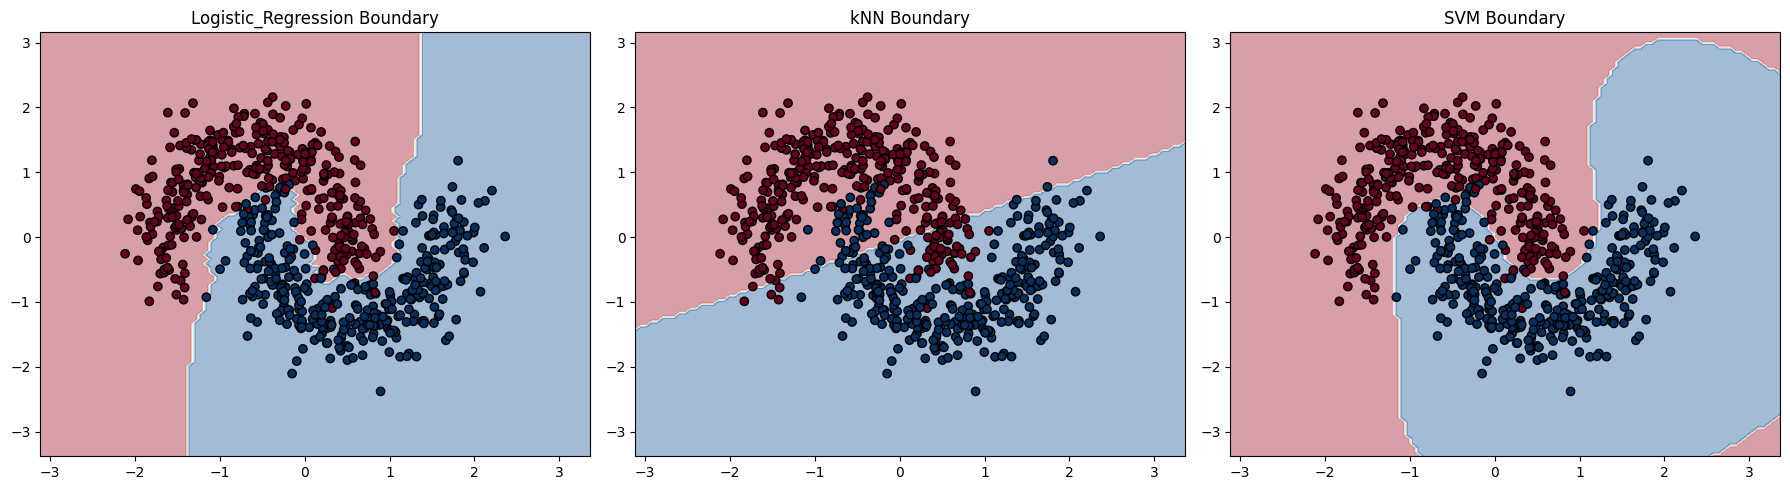

In [8]:
print("Generating Decision Boundaries for Non-Linear Data...")

# Select models
selected_models_names = ['Logistic_Regression', 'kNN', 'SVM']
models_to_plot = [row['Estimator'] for row in results_data if row['Dataset'] == 'Non-Linear' and row['Model'] in selected_models_names]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(models_to_plot):
    DecisionBoundaryDisplay.from_estimator(
        model, X_train_nl, alpha=0.4, ax=axes[i], cmap='RdBu', response_method='predict'
    )
    axes[i].scatter(X_train_nl[:, 0], X_train_nl[:, 1], c=y_train_nl, edgecolor='k', cmap='RdBu')
    axes[i].set_title(f"{selected_models_names[i]} Boundary")

plt.tight_layout()
plt.show()

# 8. Visualization: Learning Curves (Bias-Variance Trade-off)
Analyzing Overfitting vs. Generalization for MLP and SVM on High-Dimensional data.
*   **Gap between lines:** Indicates Variance (Overfitting).
*   **Low scores:** Indicates Bias (Underfitting).


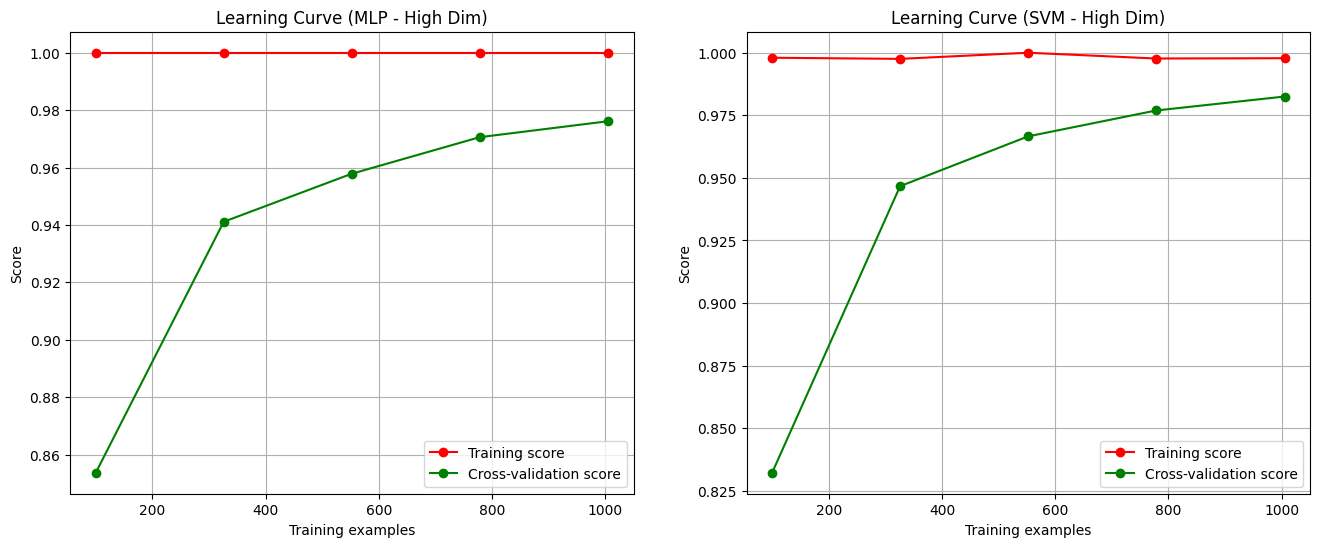

In [9]:
def plot_learning_curve(estimator, title, X, y, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")
    ax.grid()

# Select MLP and SVM from High-Dimensional results
mlp_model = [row['Estimator'] for row in results_data if row['Dataset'] == 'High-Dimensional' and row['Model'] == 'MLP'][0]
svm_model = [row['Estimator'] for row in results_data if row['Dataset'] == 'High-Dimensional' and row['Model'] == 'SVM'][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_learning_curve(mlp_model, "Learning Curve (MLP - High Dim)", X_train_high, y_train_high, axes[0])
plot_learning_curve(svm_model, "Learning Curve (SVM - High Dim)", X_train_high, y_train_high, axes[1])

plt.show()